In [3]:
#拡張機能のインポート
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#各変数の初期設定
N = 100 #データ数
D = 3   #データの次元数
L = 2   #潜在空間の次元数
T = 200 #総学習回数(epoch数のこと)
#観測データの生成の際に用いる変数
seed = 0
noise_scale = 0.05
np.random.seed(seed)
sigma = 0.3
eta = 1.0

In [4]:
#使用する観測データ
def gen_saddle_shape(num, seed, noise_scale):
    np.random.seed(seed)
    z1 = np.random.uniform(low=-1, high=+1, size=(num,))
    z2 = np.random.uniform(low=-1, high=+1, size=(num,))

    X = np.empty((num, 3))
    X[:, 0] = z1
    X[:, 1] = z2
    X[:, 2] = 0.5 * (z1**2 - z2**2)
    X += np.random.normal(loc=0, scale=noise_scale, size=X.shape)

    return X

Xのシェイプ (100, 3)


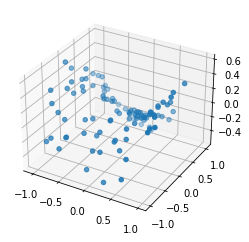

In [5]:
#観測データの描画(データの確認)
X = gen_saddle_shape(N, seed, noise_scale)
print("Xのシェイプ",X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') #三次元マップの描画
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
plt.show()

In [6]:
#初期化、潜在変数zを乱数によって初期化
Z = np.random.rand(N, L)*0.01
print(Z.shape)

(100, 2)


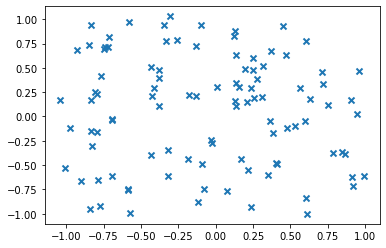

In [7]:
#Xの値
plt.close()
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1],marker='x', linewidth=2)
plt.show()

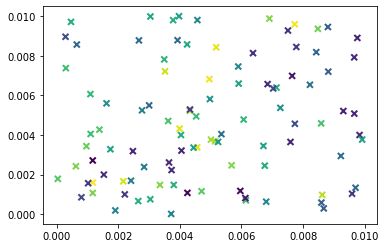

In [8]:
#Zの値
plt.close()
plt.scatter(Z[:, 0], Z[:, 1],c=X[:, 0], marker='x', linewidth=2)

In [9]:
#データの距離
def distance_function(Z1,Z2):
    distance= np.sum((Z1[:, None, :]-Z2[None, :, :])**2, axis=2)
    return distance
Distance = distance_function(Z,Z)
Distance.shape

(100, 100)

In [10]:
#写像の推定
def estimate_Y (sigma,X,Z1,Z2):
  k = np.exp((-1/(2*sigma**2))*distance_function(Z1,Z2))
  K = np.sum(k,axis=1,keepdims=True)
  Y = (k@X)/K
  return Y

In [11]:
#潜在変数の推定
def estimate_Z(sigma,Z1,Z2,X,Y,eta):
  k = np.exp((-1/(2*sigma**2))*distance_function(Z1,Z2))
  K = np.sum(k,axis=1,keepdims=True)
  r = k/K #N*N
  d_ij = Y[:,None]-X[None,:] #N*N*D
  d_nn = Y-X #N*D
  delta = Z1[:,None]-Z2[None,:] #N*N*L
  #誤差関数の微分 (8)式 : (2/(N*sigma**2))*C (B = A+A_T) (C = Σ[B○δ])
  A = np.einsum("ni,nd,nid->ni",r,d_nn,d_ij) #N*I
  B = A+A.T #N*I
  C = np.einsum("ni,nil->nl",B,delta)
  dE = (2/(N*sigma**2))*C
  #勾配法による潜在変数の更新
  Z_new = Z1-eta*dE
  return Z_new


In [12]:
#以下図をanimationで見るためのコードを書く
f_reso=10
#シェイプのTの部分でanimationを行う
history_Z = np.zeros((T, N, L))
history_y = np.zeros((T, N, D))
history_f = np.zeros((T,f_reso,f_reso,D))

for t in range(T):
  Y = estimate_Y(sigma,X,Z,Z)
  Z = estimate_Z(sigma,Z,Z,X,Y,eta)
  history_y[t] = Y
  history_Z[t] = Z
  A = np.linspace(-1,1,f_reso)
  B = np.linspace(-1,1,f_reso)
  XX, YY = np.meshgrid(A,B)
  xx = XX.reshape(-1)
  yy = YY.reshape(-1)
  M = np.concatenate([xx[:, None], yy[:, None]], axis=1) #変数表でいうζkに該当する
  f = estimate_Y(sigma,X,M,Z)
  history_f[t] = f.reshape(f_reso,f_reso,D)

#f = history_y.reshape(T,10,10,D)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax_observable = fig.add_subplot(122, projection='3d')
ax_latent = fig.add_subplot(121)
#%matplotlib nbagg

def update(i, z, f, x):
    #plt.cla()
    ax_latent.cla()
    ax_observable.cla()

    fig.suptitle(f"epoch: {i}")

    ax_latent.scatter(z[i, :, 0], z[i, :, 1], s=50, edgecolors="k", c=x[:, 0])
    
    ax_latent.set_xlim(z[:, :, 0].min(), z[:, :, 0].max())
    ax_latent.set_ylim(z[:, :, 1].min(), z[:, :, 1].max())

    ax_observable.scatter(x[:, 0], x[:, 1],x[:, 2], c=x[:, 0], s=50, marker='x')
    ax_observable.plot_wireframe(f[i, :, :, 0], f[i, :, :, 1],f[i, :, :, 2], color='black')
    

    ax_observable.set_xlim(x[:, 0].min(), x[:, 0].max())
    ax_observable.set_ylim(x[:, 1].min(), x[:, 1].max())

ani = animation.FuncAnimation(fig, update, fargs=(history_Z, history_f , X), interval=50, frames=T)
#ani.save("change_ver2.gif", writer = "pillow")
HTML(ani.to_jshtml())